# Tutorial 1: Bases and Domains

**Overview:** This tutorial covers the basics of setting up and interacting with basis and domain objects in Dedalus.
Dedalus uses spectral discretizations to represent fields and solve PDEs.
These discretizations are specified by selecting a spectral basis for each spatial dimension, and combining them to form a domain.
When running in parallel, domains are automatically distributed using a block decomposition.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dedalus import public as de

In [2]:
%matplotlib inline

## 1.1: Bases

### Creating a basis

Each type of basis in Dedalus is represented by a separate class.
These classes define the corresponding spectral operators and transforms between the "grid space" and "coefficient space" representations of functions in that basis.
The most commonly used bases are:

* `Fourier` for periodic functions on an interval.
* `SinCos` for functions with definite parity (even or odd symmetry) around the endpoints of an interval.
* `Chebyshev` for general functions on an interval.

When instantiating one of these bases, you provide a name for the spatial dimension, the number of modes, and the endpoints of the basis interval.
Optionally, you can specify a dealiasing scale factor, indicating how much to pad the included modes when transforming to grid space.
To properly dealias quadratic nonlinearities, for instance, you would need a scaling factor of 3/2.

In [3]:
xbasis = de.Chebyshev('x', 32, interval=(0,1), dealias=3/2)

Other less commonly used bases include:

* `Legendre` for general functions on an interval (but without fast transforms).
* `Hermite` for decaying functions on the real line.
* `Laguerre` for decaying functions on the half-line.

See the [basis.py API documentation](https://dedalus-project.readthedocs.io/en/latest/autoapi/dedalus/core/basis/index.html) for more information about using these other bases.

### Basis grids and scale factors

Each basis has a corresponding grid that can be used for tasks like initializing and plotting fields.
The global (non-distributed) grid of a basis can be accessed using the basis object's `grid` method, where you'll have to pass a scale factor determining the number of points in the grid, relative to the number of basis modes.
Let's look at the Chebyshev grids with scaling factors of 1 and 3/2.

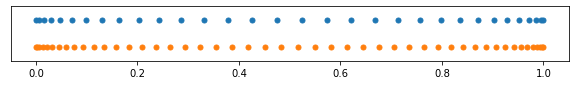

In [4]:
grid_normal = xbasis.grid(scale=1)
grid_dealias = xbasis.grid(scale=3/2)

plt.figure(figsize=(10, 1))
plt.plot(grid_normal, 0*grid_normal+1, 'o', markersize=5)
plt.plot(grid_dealias, 0*grid_dealias-1, 'o', markersize=5)
plt.ylim([-2, 2])
plt.gca().yaxis.set_ticks([]);

Note that the Chebyshev grids are non-equispaced: the grid points cluster quadratically towards the ends of the interval, which can be very useful for resolving sharp features like boundary layers.

### Compound bases

It may be useful to add resolution at a particular intermediate position in an interval.
In this case, a compound basis consisting of stacked Chebyshev segments (or other polynomial basis segments) can be constructed simply by grouping a set of individual bases defined over adjacent intervals into a `Compound` basis object.

In [5]:
xb1 = de.Chebyshev('x1', 16, interval=(0,2))
xb2 = de.Chebyshev('x2', 32, interval=(2,8))
xb3 = de.Chebyshev('x3', 16, interval=(8,10))
xbasis = de.Compound('x', (xb1, xb2, xb3))

Since we use the interior roots grid for the Chebyshev polynomials, the grid of the compound bases is simply the union of the subbasis grids.  When solving a problem with Dedalus, the continuity of fields across the subbasis interfaces is automatically enforced.

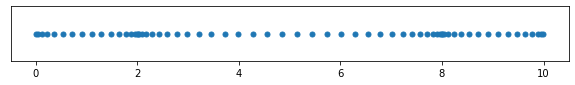

In [6]:
compound_grid = xbasis.grid(scale=1)

plt.figure(figsize=(10, 1))
plt.plot(compound_grid, 0*compound_grid, 'o', markersize=5)
plt.gca().yaxis.set_ticks([]);

## 1.2: Domains

### Creating a domain

`Domain` objects represent physical domains which are discretized by the direct product of a set of bases.  To build a domain, we pass a list of the composite bases, specify the (grid space) datatype, and optionally specify a process mesh for parallelization.  Let's construct a domain representing a 3D slab that is periodic in the x and y directions, and non-periodic in z.

In [7]:
xbasis = de.Fourier('x', 32, interval=(0,2), dealias=3/2)
ybasis = de.Fourier('y', 32, interval=(0,2), dealias=3/2)
zbasis = de.Chebyshev('z', 32, interval=(0,1), dealias=3/2)
domain = de.Domain([xbasis, ybasis, zbasis], grid_dtype=np.complex128)

Dedalus currently supports explicit computations on arbitrary N-dimensional domains.
However, to solve PDEs with Dedalus, the first (N-1) dimensions of the domain must be separable, meaning that the linear parts of the PDE do not couple different modes in these dimensions.
In most cases, this means the first (N-1) dimensions of the domain need to be either `Fourier` or `SinCos` bases.

### Parallelization & process meshes

When running in an MPI environment, Dedalus uses block-distributed domain decompositions to parallelize computation.
By default, problems are distributed across a 1-dimensional mesh of all the available MPI processes (i.e. a "slab" decomposition).
However, arbitrary (N-1)-dimensional process meshes (i.e. "pencil" decompositions) can be used by specifying a mesh shape with the `mesh` keyword when instantiating a domain.
The current MPI environment must have the same number of processes as the product of the mesh shape.

### Layouts

The domain object builds the machinery necessary for the parallelized allocation and transformation of fields.  This includes an ordered set of `Layout` objects describing the necessary transform/distribution states of the data between coefficient space and grid space.
Subsequent layouts are connected by basis transforms, which must be performed locally, and global transposes (rearrangements of the data distribution across the process mesh) to achieve the required locality.

The general algorithm starts from coefficient space (layout 0), with the last axis local (non-distributed).
It proceeds towards grid space by transforming the last axis into grid space (layout 1).
Then it globally transposes the data (if necessary) such that the penultimate axis is local, transforms that axis into grid space, etc., until all axes have been transformed to grid space (the last layout).

Let's examine the layouts for the domain we just constructed.
For serial computations such as this, no global transposes are necessary (all axes are always local), and the paths between layouts consist of coefficient-to-grid transforms, backwards from the last axis:

In [8]:
for layout in domain.distributor.layouts:
    print('Layout {}:  Grid space: {}  Local: {}'.format(layout.index, layout.grid_space, layout.local))

Layout 0:  Grid space: [False False False]  Local: [ True  True  True]
Layout 1:  Grid space: [False False  True]  Local: [ True  True  True]
Layout 2:  Grid space: [False  True  True]  Local: [ True  True  True]
Layout 3:  Grid space: [ True  True  True]  Local: [ True  True  True]


To see how things work for a distributed simulation, we'll change the specified process mesh shape and rebuild the layout objects, circumventing the internal checks on the number of available processes, etc.

**Note this is for demonstration only... messing with these attributes will generally break things.**

In [9]:
# Don't do this. For illustration only.
domain.distributor.mesh = np.array([4, 2])
domain.distributor.coords = np.array([0, 0])
domain.distributor._build_layouts(domain, dry_run=True)

In [10]:
for layout in domain.distributor.layouts:
    print('Layout {}:  Grid space: {}  Local: {}'.format(layout.index, layout.grid_space, layout.local))

Layout 0:  Grid space: [False False False]  Local: [False False  True]
Layout 1:  Grid space: [False False  True]  Local: [False False  True]
Layout 2:  Grid space: [False False  True]  Local: [False  True False]
Layout 3:  Grid space: [False  True  True]  Local: [False  True False]
Layout 4:  Grid space: [False  True  True]  Local: [ True False False]
Layout 5:  Grid space: [ True  True  True]  Local: [ True False False]


We can see that there are now two additional layouts, corresponding to the transposed states of the mixed-transform layouts.
Two global transposes are necessary here in order for the $y$ and $x$ axes to be stored locally, which is required to perform the respective basis transforms.
Here's a sketch of the data distribution in the different layouts:

<img src="fig_layouts_fold.png" width="800px">

Interacting with the layout objects directly is typically not necessary, but being aware of this system for controlling the distribution and tranformation state of data is important for interacting with field objects, as we'll see in future notebooks.

### Distributed grid and element arrays

To help with creating field data, Dedalus domain objects provide properly oriented arrays representing the local portions of the basis grids and elements (wavenumbers or polynomial indices).
The local grids (distributed according to the last layout, grid space) are accessed using the `domain.grid` method and specifying an axis and scale factors:

In [11]:
local_x = domain.grid(0, scales=1)
local_y = domain.grid(1, scales=1)
local_z = domain.grid(2, scales=1)
print('Local x shape:', local_x.shape)
print('Local y shape:', local_y.shape)
print('Local z shape:', local_z.shape)

Local x shape: (32, 1, 1)
Local y shape: (1, 8, 1)
Local z shape: (1, 1, 16)


The local x grid is the full Fourier grid for the x-basis, and will be the same on all processes, since the first axis is local in grid space.
The local y and local z grids will generally differ across processes, since they contain just the local portions of the y and z basis grids, distributed across the specified process mesh (4 blocks in y and 2 blocks in z).

The local elements (distributed according to layout 0) are accessed using the `domain.elements` method and specifying an axis:

In [12]:
local_kx = domain.elements(0)
local_ky = domain.elements(1)
local_nz = domain.elements(2)
print('Local kx shape:', local_kx.shape)
print('Local ky shape:', local_ky.shape)
print('Local nz shape:', local_nz.shape)

Local kx shape: (8, 1, 1)
Local ky shape: (1, 16, 1)
Local nz shape: (1, 1, 32)


The local kx and local ky elements will now differ across processes, since they contain just the local portions of the x and y wavenumbers, which are distributed in coefficient space.
The local nz elements are the full set of Chebyshev modes, which are always local in coefficient space.

These local arrays can be used to form parallel-safe initial conditions for fields, in grid or coefficient space, as we'll see in the next notebook.